In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
import vsm
from lib_classification import *
from pathlib import Path, PureWindowsPath
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) #pour ignorer les warnings de type "deprecated"
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans les colonnes du dataframe
np.set_printoptions(suppress=True) # notation scientifique desactivee

(lib_classification.py : sys.path = ['..', '../..', 'c:\\Users\\eupho\\OneDrive\\Documents\\perso\\projets\\classification_texte_articles\\sources\\classification', 'C:\\Users\\eupho\\OneDrive\\Documents\\perso\\formations\\nlu_stanford\\cs224u', 'c:\\Users\\eupho\\anaconda3\\python39.zip', 'c:\\Users\\eupho\\anaconda3\\DLLs', 'c:\\Users\\eupho\\anaconda3\\lib', 'c:\\Users\\eupho\\anaconda3', '', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.9.egg', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages\\win32', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages\\Pythonwin', 'c:\\Users\\eupho\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\eupho\\.ipython']


In [2]:
def get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=test_size, random_state=random_state)

    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    svd = TruncatedSVD(n_components=n_components_svd, n_iter=7, random_state=42)
    X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
    hashing_vectorizer = HashingVectorizer()
    
    X_train_hashing = hashing_vectorizer.fit_transform(X_train)
    X_train_observed_expected = vsm.observed_over_expected(X_train_count)
    X_train_pmi = vsm.pmi(X_train_count)
    svd = TruncatedSVD(n_components=n_components_svd, n_iter=7, random_state=42)
    X_train_pmi_svd = svd.fit_transform(X_train_pmi)

    X_test_count = count_vectorizer.transform(X_test)
    X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    X_test_hashing = hashing_vectorizer.transform(X_test)
    X_test_tfidf_svd = svd.transform(X_test_tfidf)
    X_test_observed_expected = vsm.observed_over_expected(X_test_count)
    X_test_pmi = vsm.pmi(X_test_count)
    X_test_pmi_svd = svd.transform(X_test_pmi) 

    transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi",
                                "pmi + lsa", "tfidf + lsa"]
    matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                            X_train_observed_expected, X_train_pmi, X_train_pmi_svd, X_train_tfidf_svd]
    matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                        X_test_observed_expected, X_test_pmi, X_test_pmi_svd, X_test_tfidf_svd]
                        
    return(transformations_names, matrices_train, matrices_test)

In [8]:
# os.chdir("../..")
set_current_directory_to_root(root = "classification_texte_articles")

print(os.getcwd())
filename = "corpus_feser_pruss.csv"
path = "./data/input/merged_corpus/{}".format(filename)
corpus = pd.read_csv(path)
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")
corpus_name = get_corpus_name_from_filename(filename)

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_articles
inside function get_balanced_binary_dataset
in get_corpus_name_from_filename
filename = corpus_feser_pruss.csv
filename.split('.') = ['corpus_feser_pruss', 'csv']
filename.split('.')[0] = corpus_feser_pruss
0    629
1    629
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,message,message_preprocessed,category,length,category_bin,id
0,"Now, if the faithful can raise questions, doubts, and inquiries even where expressions of _Catholic doctrine_ are concerned, then _a fortiori_ they can raise questions, doubts, and inquiries where apparent _conflicts_ with Catholic doctrine are concerned. For example, they can do so with respect to the problematic “ambiguity” in _Amoris Laetitia_ referred to by Benedict XVI. How could this possibly _not_ be permissible, by Pope Francis’s own lights? That is to say, how could it be permissible to “pose questions, doubts, inquiries” about perennial Catholic teaching on marriage and the Eucharist, but not permissible to pose them about a passage in a recent exhortation that fails clearly to reaffirm that traditional teaching?",faithful raise question doubt inquiry even expression catholic doctrine concerned fortiori raise question doubt inquiry apparent conflict catholic doctrine concerned example respect problematic “ ambiguity ” amoris laetitia referred benedict xvi could possibly permissible pope light say could permissible “ pose question doubt inquiry ” perennial catholic teaching marriage eucharist permissible pose passage recent exhortation fails clearly reaffirm traditional teaching,feser,732,0,0
1,"There are empirical indications that various skills and maybe even virtues are pretty domain specific. It seems that being good at reasoning about one thing need not make one good at reasoning about another, even if the reasoning is formally equivalent.",empirical indication various skill maybe even virtue pretty domain specific seems good reasoning one thing need make one good reasoning another even reasoning formally equivalent,pruss,253,1,1
...,...,...,...,...,...,...
1256,"But what’s a reasonable threshold for belief? Maybe something like 0.9 or 0.95. At _r_ = 0.9, the squishiness needed for paradox is _α_ = 0.046. I suspect our credences are more precise than that. If we agree that the squishiness of our credences is less than 4.6%, then we have an argument that the threshold for belief is _more_ than 0.9. On the other hand, at _r_ = 0.95, the squishiness needed for paradox is 2.4%. At this point, it becomes more plausible that our credences lack that kind of precision, but it’s not clear. At _r_ = 0.98, the squishiness needed for paradox dips below 1%. Depending on how precise we think our credences are, we get an argument that the threshold for belief is something like 0.95 or 0.98.",reasonable threshold belief maybe something like r squishiness needed paradox α suspect credence precise agree squishiness credence le argument threshold belief hand r squishiness needed paradox point becomes plausible credence lack kind precision clear r squishiness needed paradox dip depending precise think credence get argument threshold belief something like,pruss,726,1,1256
1257,"@Michael It seems to me that Ed criticism of ID seems that it tends to aproach things with exactly the wrong nominalist metaphysics of the materialists* and so fails to let the atheist see that his world view is absurd in every way, not only on its lack of a God. He also said before that the view failure to give us more that a demiurge tends to promote a wrong conception of God that the atheists do find reasonable problems with, not the real One. Now, are these dificulties enough to dismiss the whole thing? Perhaps or perhaps not, i admit that i dont know ID. But it does seems to be a block against getting people to think in ur-platonists ways, and that is bad. *can it do diferently? I dont know.",michael seems ed criticism id seems tends aproach thing exactly wrong nominalist metaphysics materialist fails let atheist see world view absurd every way lack god also said view failure give u demiurge tends promote wrong conception god atheist find reasonable problem real one dificulties enough dismiss whole thing perhaps perhaps admit dont know id seems block getting people think ur-platonists way ba

In [5]:
X = corpus["message_preprocessed"]
# y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# X_train = X_train.iloc[0:500]

In [12]:
test_size = 0.33
random_state = 42
n_components_svd = 2000
transformations_names, matrices_train, matrices_test = get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd)
print(transformations_names)

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


['count', 'normalized', 'tfidf', 'hashing', 'observed_expected', 'pmi', 'pmi + lsa', 'tfidf + lsa']


In [13]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)

X_train_observed_expected = vsm.observed_over_expected(X_train_count).round(2)
# X_train_observed_expected = np.ravel(X_train_observed_expected)
# X_train_observed_expected = np.delete(X_train_observed_expected, np.where(X_train_observed_expected == 0))

X_train_pmi = vsm.pmi(X_train_count)

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


In [10]:
def make_data_exploration_output_dir(dataset_name):
    if not os.path.exists("./data/output/{}".format(dataset_name)):
        os.makedirs("./data/output/{}".format(dataset_name))
    if not os.path.exists("./data/output/{}/data_exploration".format(dataset_name)):
        os.makedirs("./data/output/{}/data_exploration".format(dataset_name))

make_data_exploration_output_dir(corpus_name)

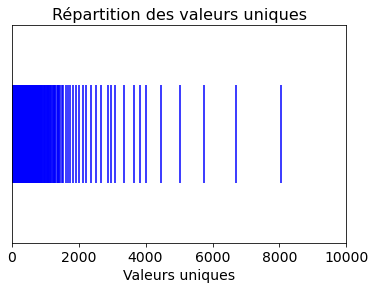

In [14]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
path = "./data/output/{}/data_exploration/observed_expected_matrix_unique_distribution.png".format(corpus_name)

plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(np.unique(X_train_observed_expected), orientation='horizontal', colors='b')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.xlim(0, 10000)
plt.savefig(path)
plt.show()

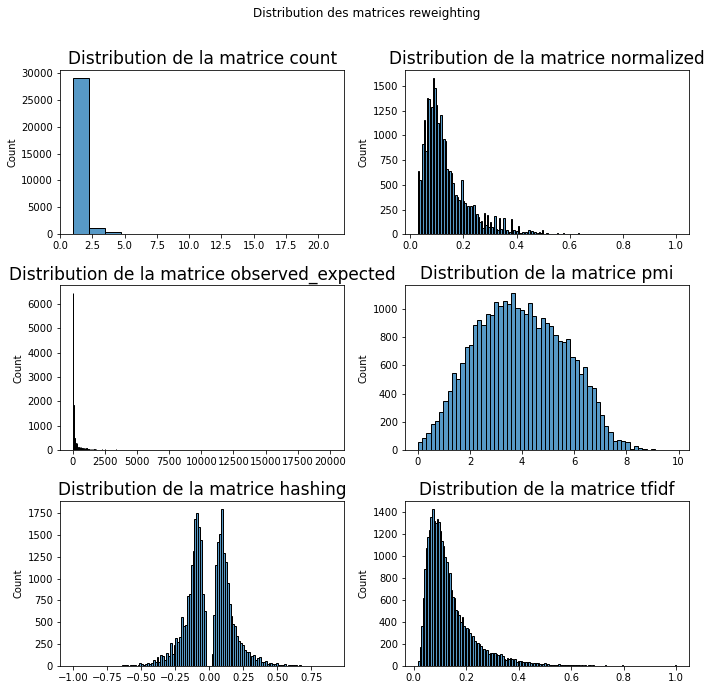

In [15]:
# Plot de toutes les distributions de matrices cote a cote
# Count, normalisation L2, expected observed, pmi, hashing, tfidf = 5 graphiques
path = "./data/output/{}/data_exploration/count_matrix_reweighting_distribution.png".format(corpus_name)

fig, axes = plt.subplots(3, 2, figsize = (10, 10)) # Create a figure for 2 subplots (1 row, 2 columns)
fig.suptitle('Distribution des matrices reweighting')
fig.tight_layout(pad=3.0) #espace entre les graphiques

sb.histplot(X_train_count.data, edgecolor="black", linewidth=1, ax=axes[0,0])
axes[0,0].set_title("Distribution de la matrice count", size=17)

sb.histplot(X_train_normalized.data, edgecolor="black", linewidth=1, ax=axes[0,1])
axes[0,1].set_title("Distribution de la matrice normalized", size=17)

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1, ax=axes[1,0])
axes[1,0].set_title("Distribution de la matrice observed_expected", size=17)

sb.histplot(np.ravel(X_train_pmi[X_train_pmi != 0]), edgecolor="black", linewidth=1, ax=axes[1,1])
axes[1,1].set_title("Distribution de la matrice pmi", size=17)

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1, ax=axes[2,0])
axes[2,0].set_title("Distribution de la matrice hashing", size=17)

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1, ax=axes[2,1])
axes[2,1].set_title("Distribution de la matrice tfidf", size=17)

plt.savefig(path)

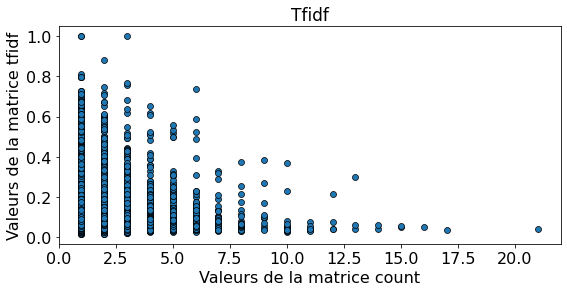

In [16]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice tfidf
path = "./data/output/{}/data_exploration/tfidf_vs_count_distribution.png".format(corpus_name)

sb.scatterplot(x=X_train_count.data, y=X_train_tfidf.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice tfidf", size=16)
plt.title("Tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

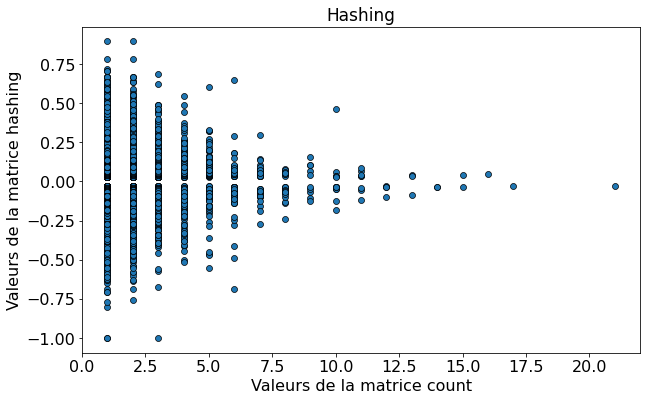

In [17]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice hashing
path = "./data/output/{}/data_exploration/hashing_vs_count_distribution.png".format(corpus_name)

sb.scatterplot(x=X_train_count.data, y=X_train_hashing.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

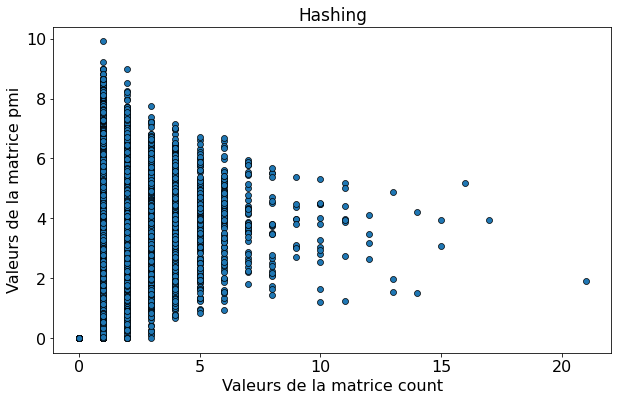

In [18]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice pmi
path = "./data/output/{}/data_exploration/pmi_vs_count_distribution.png".format(corpus_name)

sb.scatterplot(x=np.ravel(X_train_count.toarray()), y=np.ravel(X_train_pmi), edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice pmi", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

Tests de performances sur plusieurs transformations de matrices (reweighting)

In [36]:
X_train_tfidf.shape

(2456, 9694)

In [39]:
# Reduction de dimension truncated svd/lsa apres tfidf 
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
# print(X_train_tfidf_svd)
plt.rcParams["figure.figsize"] = (10, 6)
# sb.histplot(np.ravel(X_train_tfidf_svd[X_train_tfidf_svd != 0]), edgecolor="black", linewidth=1)
# plt.xlim(-0.2, 0.2)
svd.explained_variance_ratio_.sum()

0.9819463303212571

c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


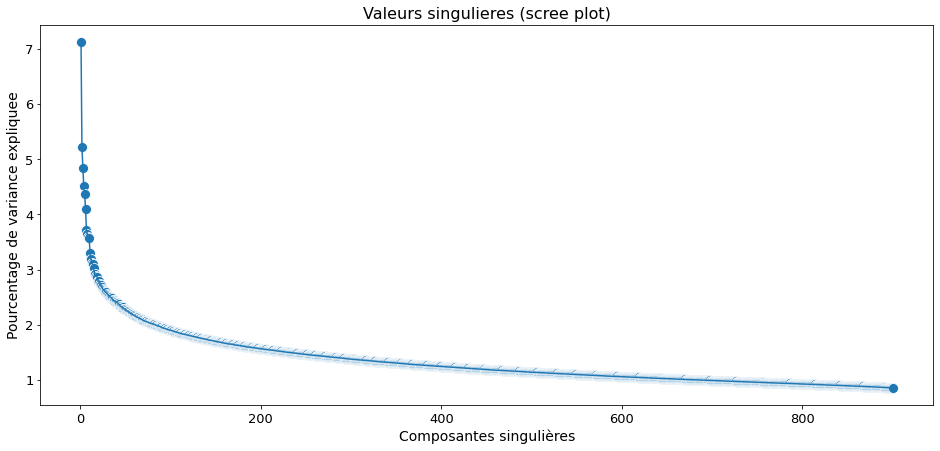

In [94]:
# Scree plot (graphe d'eboulis) = plot des valeurs singulieres (dans l'ordre decroissant)
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, svd.singular_values_)
sb.scatterplot(x, svd.singular_values_, s=100)
plt.xlabel("Composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Valeurs singulieres (scree plot)", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

pourcentage variance expliquee par toutes les variables svd = 77.59512315804677
pourcentage variance expliquee par les 40 premieres variables svd = 16.223060628043378


c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


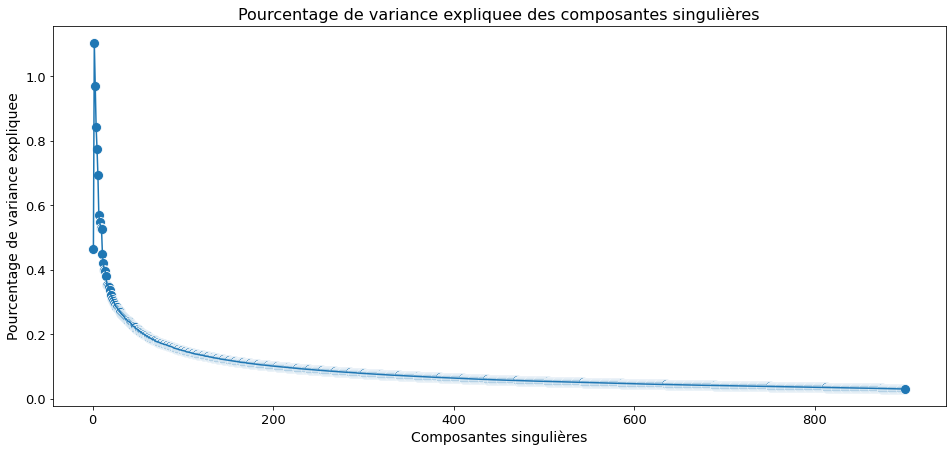

In [95]:
# Pourcentage de variance expliquee des composantes singulières
n_dim_chosen = 200
# print("pourcentage variance expliquee =", svd.explained_variance_ratio_ * 100)
print("pourcentage variance expliquee par toutes les variables svd =", svd.explained_variance_ratio_.sum() * 100)
print("pourcentage variance expliquee par les 40 premieres variables svd =", svd.explained_variance_ratio_[:40].sum() * 100)
# sb.barplot(data=df_explained_var, x=0, y=1)
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, svd.explained_variance_ratio_ * 100)
sb.scatterplot(x, svd.explained_variance_ratio_ * 100, s=100)
plt.xlabel("Composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Pourcentage de variance expliquee des composantes singulières", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


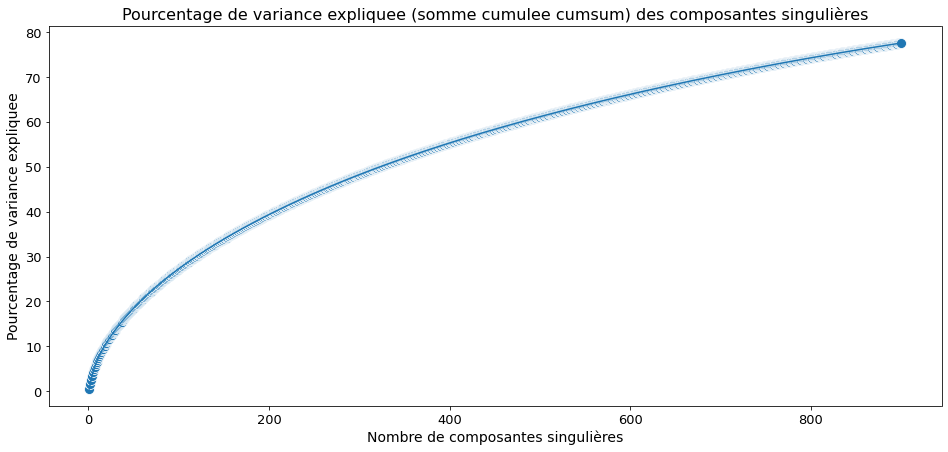

In [98]:
# Pourcentage de variance expliquee (somme cumulee cumsum) des composantes singulières
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, np.cumsum(svd.explained_variance_ratio_) * 100)
sb.scatterplot(x, np.cumsum(svd.explained_variance_ratio_) * 100, s=100)
plt.xlabel("Nombre de composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Pourcentage de variance expliquee (somme cumulee cumsum) des composantes singulières", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

In [30]:
# Performance du modele en fonction du nombre de dimensions gardees avec svd
num_iter = 5
scoring = ['f1_macro', 'recall']
min_dim = 2
max_dim = 2000
# max_dim = 900
step_dim = -100
list_num_dim = list(range(max_dim, min_dim, step_dim))
scores_f1 = []
scores_recall = []
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print("debut")
for n_components in list_num_dim:
    svd = TruncatedSVD(n_components, n_iter=7, random_state=42)
    X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
    print("n_components = {} ; explained_variance_ratio_ = {}".format(n_components, sum(svd.explained_variance_ratio_ * 100)))

    model = SGDClassifier()
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf_svd, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4)
    scores_f1.append(cv_results["test_f1_macro"])
    scores_recall.append(cv_results["test_recall"])

debut
n_components = 2000 ; explained_variance_ratio_ = 98.19463303212576
n_components = 1900 ; explained_variance_ratio_ = 97.2904607715731
n_components = 1800 ; explained_variance_ratio_ = 96.22347297468488
n_components = 1700 ; explained_variance_ratio_ = 94.98691090112597
n_components = 1600 ; explained_variance_ratio_ = 93.5765684587774
n_components = 1500 ; explained_variance_ratio_ = 91.98136244607974
n_components = 1400 ; explained_variance_ratio_ = 90.18719498899623
n_components = 1300 ; explained_variance_ratio_ = 88.17966038408008
n_components = 1200 ; explained_variance_ratio_ = 85.93602927889162
n_components = 1100 ; explained_variance_ratio_ = 83.43811757924234
n_components = 1000 ; explained_variance_ratio_ = 80.66163501284511
n_components = 900 ; explained_variance_ratio_ = 77.5630024735008
n_components = 800 ; explained_variance_ratio_ = 74.11590501997574
n_components = 700 ; explained_variance_ratio_ = 70.26194575888246
n_components = 600 ; explained_variance_ratio_ =

20

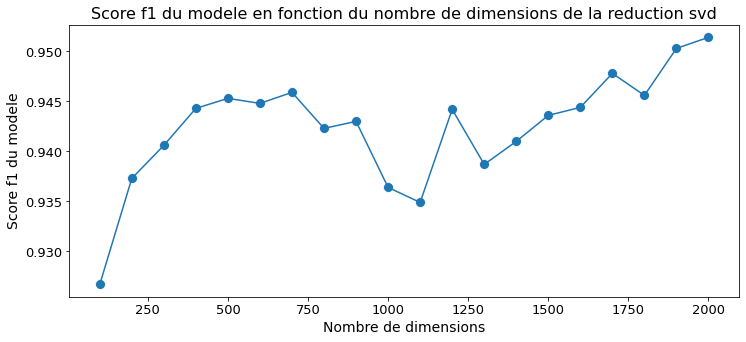

In [34]:
# Score f1 du modele en fonction du nombre de dimensions de la reduction svd
sb.lineplot(list_num_dim, scores_f1)
sb.scatterplot(list_num_dim, scores_f1, s=100)
plt.xlabel("Nombre de dimensions", size=14)
plt.ylabel("Score f1 du modele", size=14)
plt.title("Score f1 du modele en fonction du nombre de dimensions de la reduction svd", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.rcParams["figure.figsize"] = (12, 5)
len(scores_f1)

20

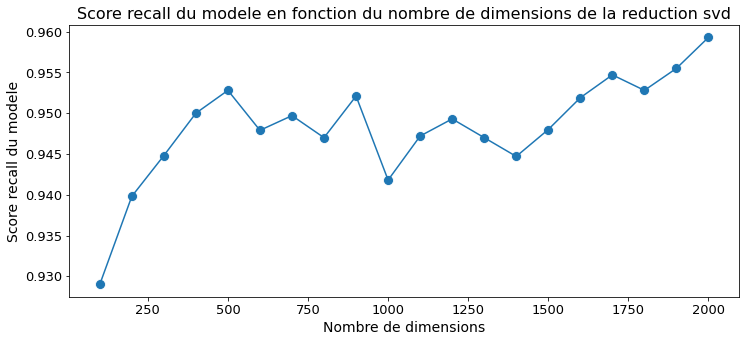

In [35]:
# Score scores_recall du modele en fonction du nombre de dimensions de la reduction svd
sb.lineplot(list_num_dim, scores_recall)
sb.scatterplot(list_num_dim, scores_recall, s=100)
plt.xlabel("Nombre de dimensions", size=14)
plt.ylabel("Score recall du modele", size=14)
plt.title("Score recall du modele en fonction du nombre de dimensions de la reduction svd", size=16)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.rcParams["figure.figsize"] = (12, 5)
len(scores_recall)

In [44]:
# Methode 1 : automatique (cross validation de sklearn)
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) #pour ignorer les warnings de type "deprecated"

# X = corpus["message_preprocessed"]
# # y = corpus["category"]
# y = corpus["category_bin"]
# indices = corpus["id"]
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

# count_vectorizer = CountVectorizer()
# X_train_count = count_vectorizer.fit_transform(X_train)
# X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
# tfidf_vectorizer = TfidfVectorizer()
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# hashing_vectorizer = HashingVectorizer()
# X_train_hashing = hashing_vectorizer.fit_transform(X_train)
# X_train_observed_expected = vsm.observed_over_expected(X_train_count)
# X_train_pmi = vsm.pmi(X_train_count)

# X_test_count = count_vectorizer.transform(X_test)
# X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
# X_test_tfidf = tfidf_vectorizer.transform(X_test)
# X_test_hashing = hashing_vectorizer.transform(X_test)
# X_test_tfidf_svd = svd.transform(X_test_tfidf)
# X_test_observed_expected = vsm.observed_over_expected(X_test_count)
# X_test_pmi = vsm.pmi(X_test_count)

# transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi", "tfidf + lsa"]
# matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
#                         X_train_observed_expected, X_train_pmi, X_train_tfidf_svd]
# matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
#                     X_test_observed_expected, X_test_pmi, X_test_tfidf_svd]

test_size = 0.33
random_state = 42
n_components_svd = 2000
transformations_names, matrices_train, matrices_test = get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd)
print(transformations_names)

scoring = ['f1_macro', 'recall']
num_iter = 5
for i_matrix in range(len(transformations_names)):
    model = SGDClassifier()
    matrix_train = matrices_train[i_matrix]
    matrix_name = transformations_names[i_matrix]

    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, matrix_train, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(matrix_name)) #2: pour ignorer les info inutiles

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


['count', 'normalized', 'tfidf', 'hashing', 'observed_expected', 'pmi', 'pmi + lsa', 'tfidf + lsa']
[('test_f1_macro', 0.9309), ('test_recall', 0.9423)] (count)
[('test_f1_macro', 0.9475), ('test_recall', 0.9567)] (normalized)
[('test_f1_macro', 0.9516), ('test_recall', 0.9572)] (tfidf)
[('test_f1_macro', 0.9438), ('test_recall', 0.9513)] (hashing)
[('test_f1_macro', 0.8137), ('test_recall', 0.8094)] (observed_expected)
[('test_f1_macro', 0.9258), ('test_recall', 0.9505)] (pmi)
[('test_f1_macro', 0.9239), ('test_recall', 0.9465)] (pmi + lsa)
[('test_f1_macro', 0.9497), ('test_recall', 0.9593)] (tfidf + lsa)


In [ ]:
# resultats sur philosophy_baptism
# [('test_f1_macro', 0.9356), ('test_recall', 0.9455)] (count)
# [('test_f1_macro', 0.945), ('test_recall', 0.9513)] (normalized)
# [('test_f1_macro', 0.9519), ('test_recall', 0.9575)] (tfidf)
# [('test_f1_macro', 0.9467), ('test_recall', 0.9526)] (hashing)
# [('test_f1_macro', 0.8107), ('test_recall', 0.8132)] (observed_expected)
# [('test_f1_macro', 0.9271), ('test_recall', 0.9381)] (pmi)
# [('test_f1_macro', 0.9195), ('test_recall', 0.9224)] (tfidf + lsa)

In [102]:
# Methode 2 : manuelle (split train test classique)
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier

transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi"]
scores = [0, 0, 0, 0, 0, 0]
num_iter = 60

In [103]:
for iter in range(num_iter):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
    
    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    hashing_vectorizer = HashingVectorizer()
    X_train_hashing = hashing_vectorizer.fit_transform(X_train)
    X_train_observed_expected = vsm.observed_over_expected(X_train_count)
    X_train_pmi = vsm.pmi(X_train_count)

    X_test_count = count_vectorizer.transform(X_test)
    X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    X_test_hashing = hashing_vectorizer.transform(X_test)
    X_test_observed_expected = vsm.observed_over_expected(X_test_count)
    X_test_pmi = vsm.pmi(X_test_count)

    matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                        X_train_observed_expected, X_train_pmi]
    matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                        X_test_observed_expected, X_test_pmi]

    for i_matrix in range(len(transformations_names)):   
        model = SGDClassifier()
        matrix_train = matrices_train[i_matrix]
        matrix_test = matrices_test[i_matrix]
        model.fit(matrix_train, y_train)
        y_pred = model.predict(matrix_test)
        scores[i_matrix] += f1_score(y_test, y_pred, average='macro')

In [104]:
for i_matrix in range(len(transformations_names)):   
    print("test_f1_macro, {} ({})".format(scores[i_matrix] / num_iter, transformations_names[i_matrix]))

test_f1_macro, 0.9442974845526717 (count)
test_f1_macro, 0.9516293917765217 (normalized)
test_f1_macro, 0.957232907995305 (tfidf)
test_f1_macro, 0.9514486520843743 (hashing)
test_f1_macro, 0.8097246471012853 (observed_expected)
test_f1_macro, 0.9366296553617979 (pmi)
